In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import muon as mu
from muon import prot as pt
import os
import h5py
from mudata import MuData
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_array
import anndata as ad

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/si

In [2]:
from sklearn.mixture import GaussianMixture  # different in updated sklearn (prev GMM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import rgb2hex

In [4]:
import milopy  # had to revert markupsafe (2.0.1) for updated version issue
import milopy.core as milo
import itertools
from distinctipy import distinctipy

In [75]:
def remove_recompute(adata):
    del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)  # using with default parameters
    sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
    return adata

def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash_onoff'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash_onoff'][z])
            rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep

def build_samplerep(adata, sample_slot, replicate_slot):
    sample_rep = [None] * adata.shape[0]
    for r in np.arange(adata.shape[0]):
        sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
    return sample_rep


def group_nhoods(adata, min_connect, max_difflfc):
    adj_nhood = np.zeros((adata.obsm['nhoods'].shape[1], adata.obsm['nhoods'].shape[1]))

    # only considering single cells belonging to more than one
    overlap_ind = np.where(np.sum(adata.obsm['nhoods'], axis=1) > 1)[0]
    for g in overlap_ind:
        nhood_ind = np.where(adata.obsm['nhoods'][g, :].todense() == 1)[1]
        ij = list(itertools.permutations(nhood_ind, 2))
        for q in ij:
            adj_nhood[q] = adj_nhood[q] + 1

    # still need to filter adj matrix entries to zero by connections (< 3) and LFC match (diff > 0.25?)
    nonzero_ind = np.where(adj_nhood > 0)
    logFC = adata.uns['nhood_adata'].obs['logFC']
    for f in np.arange(len(nonzero_ind[0])):
        if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:
            adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] = 0

    return adj_nhood


def plot_nhood_clusters(adata, cluster_labels, title, alpha=0.1, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan

    # plotting order
    ordered = nhood_adata.obs.sort_values('SpatialFDR', na_position='last').index[::-1]
    nhood_adata = nhood_adata[ordered]

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def plot_durable_clusters(adata, cluster_labels, title, alpha=0.1, beta=0.5, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] < alpha, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] > beta, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < -beta, "graph_color"] = np.nan

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def get_sc_louvain(adata, cluster_slot='louvain'):
    louvain_onehot = np.zeros((adata.uns['nhood_adata'].obs[cluster_slot].shape[0], (np.unique(adata.uns['nhood_adata'].obs[cluster_slot])[-2] + 1).astype('int')))
    for c in adata.uns['nhood_adata'].obs[cluster_slot].index:
        if adata.uns['nhood_adata'].obs[cluster_slot][c] < float('inf'):
            louvain_onehot[int(c), adata.uns['nhood_adata'].obs[cluster_slot][c].astype('int')] = 1

    # get single-cell louvain neighborhood cluster labels
    sc_onehot = adata.obsm['nhoods']*louvain_onehot
    sc_louvain = np.zeros(sc_onehot.shape[0])
    for t in np.arange(sc_onehot.shape[0]):
        if np.sum(sc_onehot[t, :]) == 0:
            sc_louvain[t] = -1
        else:
            sc_louvain[t] = np.argmax(sc_onehot[t, :])

    return sc_louvain.astype('int')

In [6]:
rna_sing = sc.read('/Users/anasuyadighe/Downloads/cpi-cd40-main/Round4_celltypes_collapsed.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


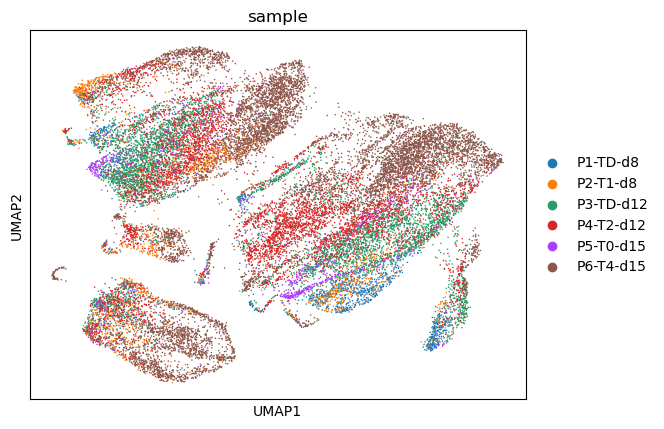

In [7]:
sc.pl.umap(rna_sing, color = 'sample')

In [8]:
rna_sing.obs['sample']

AAACCAGGTCATGAAG-1-P1-TD-d8      P1-TD-d8
AAACGGGCAGTTATGG-1-P1-TD-d8      P1-TD-d8
AAACTGGGTATTCGAC-1-P1-TD-d8      P1-TD-d8
AAACTGGGTGCACTAT-1-P1-TD-d8      P1-TD-d8
AAACTGGGTTACTCCC-1-P1-TD-d8      P1-TD-d8
                                  ...    
TTTGTGAGTGAGAAGG-1-P6-T4-d15    P6-T4-d15
TTTGTGAGTTAATTCG-1-P6-T4-d15    P6-T4-d15
TTTGTGAGTTGCGGCT-1-P6-T4-d15    P6-T4-d15
TTTGTGAGTTGGCGAG-1-P6-T4-d15    P6-T4-d15
TTTGTGAGTTTAACCA-1-P6-T4-d15    P6-T4-d15
Name: sample, Length: 25020, dtype: category
Categories (6, object): ['P1-TD-d8', 'P2-T1-d8', 'P3-TD-d12', 'P4-T2-d12', 'P5-T0-d15', 'P6-T4-d15']

In [9]:
sample_names = ['P3-TD-d12', 'P5-T0-d15']

In [10]:
d8_sample = np.where(rna_sing.obs['sample'] == 'P1-TD-d8')[0]

In [25]:
all_untreated = []
for g in sample_names:
    next_ind = np.where(rna_sing.obs['sample'] == g)[0]
    adatas = rna_sing[np.concatenate((d8_sample, next_ind)), :]
    adatas = remove_recompute(adatas)
    all_untreated.append(adatas.copy())

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_59068/3216402015.py:2: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_59068/3216402015.py:2: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/var/folders/wb/

In [30]:
all_untreated

[AnnData object with n_obs × n_vars = 3506 × 19059
     obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'pca', 'neighbors', 'umap'
     obsm: 'hash_onoff', 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 7274 × 19059
     obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'pca', 'neighbors', 'umap'
     obsm: 'hash_onoff', 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 AnnData objec

In [21]:
all_unt = []
unt_d8 = np.where(rna_sing.obs['sample'] == 'P1-TD-d8')[0]
unt_d12 = np.where(rna_sing.obs['sample'] == 'P3-TD-d12')[0]
unt_d15 = np.where(rna_sing.obs['sample'] == 'P5-T0-d15')[0]
adata = rna_sing[np.concatenate((unt_d8, unt_d12,unt_d15)), :]
all_unt.append(adata.copy())

In [32]:
all_unt

[AnnData object with n_obs × n_vars = 8231 × 19059
     obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'hashing_colors', 'leiden', 'leiden_0.6_colors', 'leiden_new_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
     obsm: 'X_pca', 'X_umap', 'hash_onoff'
     varm: 'PCs'
     obsp: 'connectivities', 'distances']

In [40]:
concatenated_data = ad.concat(all_unt, join='outer', label='sample', fill_value=0)

In [41]:
concatenated_data

AnnData object with n_obs × n_vars = 8231 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
    obsm: 'X_pca', 'X_umap', 'hash_onoff'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


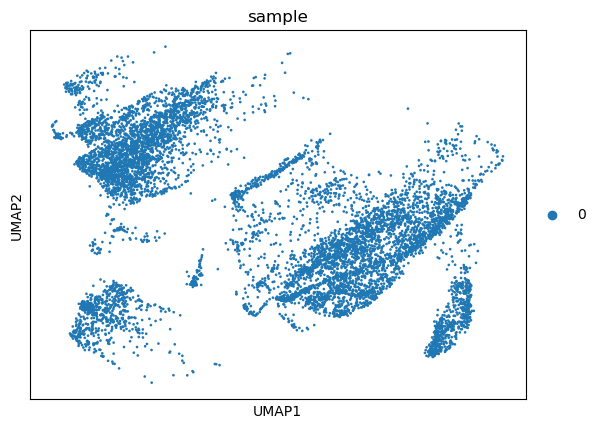

In [42]:
sc.pl.umap(concatenated_data, color = 'sample')

In [43]:
concatenated_data = remove_recompute(concatenated_data)

In [50]:
concatenated_data.obs['sample']

AAACCAGGTCATGAAG-1-P1-TD-d8     0
AAACGGGCAGTTATGG-1-P1-TD-d8     0
AAACTGGGTATTCGAC-1-P1-TD-d8     0
AAACTGGGTGCACTAT-1-P1-TD-d8     0
AAACTGGGTTACTCCC-1-P1-TD-d8     0
                               ..
TTTGCTCTCGATTGGG-1-P5-T0-d15    0
TTTGGACGTAGTAGCA-1-P5-T0-d15    0
TTTGGACGTGGTTATC-1-P5-T0-d15    0
TTTGGCGGTTTACTGA-1-P5-T0-d15    0
TTTGTGAGTCGTTCTC-1-P5-T0-d15    0
Name: sample, Length: 8231, dtype: category
Categories (1, object): ['0']

In [51]:
concatenated_data3 = ad.concat(all_unt, join='outer')
concatenated_data3

AnnData object with n_obs × n_vars = 8231 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
    obsm: 'X_pca', 'X_umap', 'hash_onoff'

In [52]:
concatenated_data3.obs['sample']

AAACCAGGTCATGAAG-1-P1-TD-d8      P1-TD-d8
AAACGGGCAGTTATGG-1-P1-TD-d8      P1-TD-d8
AAACTGGGTATTCGAC-1-P1-TD-d8      P1-TD-d8
AAACTGGGTGCACTAT-1-P1-TD-d8      P1-TD-d8
AAACTGGGTTACTCCC-1-P1-TD-d8      P1-TD-d8
                                  ...    
TTTGCTCTCGATTGGG-1-P5-T0-d15    P5-T0-d15
TTTGGACGTAGTAGCA-1-P5-T0-d15    P5-T0-d15
TTTGGACGTGGTTATC-1-P5-T0-d15    P5-T0-d15
TTTGGCGGTTTACTGA-1-P5-T0-d15    P5-T0-d15
TTTGTGAGTCGTTCTC-1-P5-T0-d15    P5-T0-d15
Name: sample, Length: 8231, dtype: category
Categories (3, object): ['P1-TD-d8', 'P3-TD-d12', 'P5-T0-d15']

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


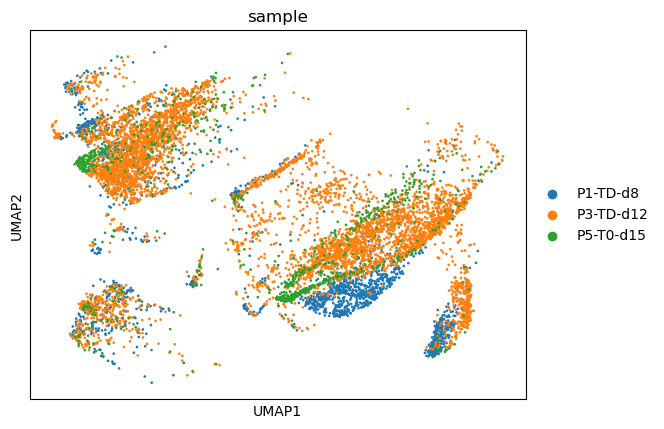

In [54]:
sc.pl.umap(concatenated_data3, color = 'sample')

In [55]:
concatenated_data3 = remove_recompute(concatenated_data3)

In [71]:
concatenated_data3.obsm['hash_onoff']

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [73]:
concatenated_data3.obs['replicate'] = encode_replicates(concatenated_data3, None)

In [72]:
#Edited encode replicates function

In [82]:
dose_dict = {'P1-TD-d8': 0,
             'P3-TD-d12': 25,
             'P5-T0-d15': 100}
concatenated_data3.obs['cond_continuous'] = concatenated_data3.obs["sample"].map(dose_dict).astype(int)


In [83]:
concatenated_data3.obs['cond_continuous']

AAACCAGGTCATGAAG-1-P1-TD-d8       0
AAACGGGCAGTTATGG-1-P1-TD-d8       0
AAACTGGGTATTCGAC-1-P1-TD-d8       0
AAACTGGGTGCACTAT-1-P1-TD-d8       0
AAACTGGGTTACTCCC-1-P1-TD-d8       0
                               ... 
TTTGCTCTCGATTGGG-1-P5-T0-d15    100
TTTGGACGTAGTAGCA-1-P5-T0-d15    100
TTTGGACGTGGTTATC-1-P5-T0-d15    100
TTTGGCGGTTTACTGA-1-P5-T0-d15    100
TTTGTGAGTCGTTCTC-1-P5-T0-d15    100
Name: cond_continuous, Length: 8231, dtype: int64

In [84]:
concatenated_data3.obs['sample_rep'] = build_samplerep(concatenated_data3, 'cond_continuous', 'replicate')
#cpi.obs['sample_rep'] = build_samplerep(cpi, 'cond_continuous', 'replicate')

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_59068/1680834334.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


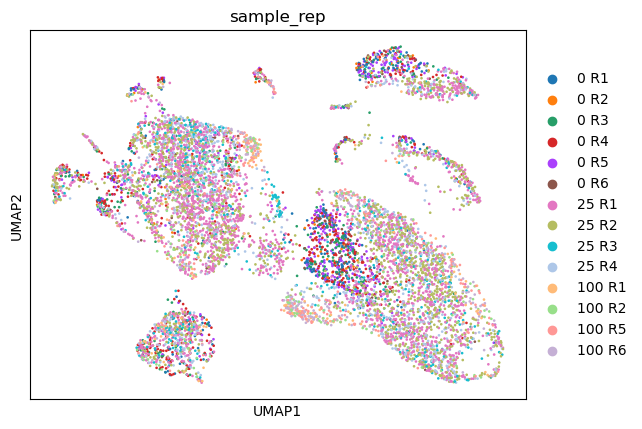

In [85]:
sc.pl.umap(concatenated_data3, color='sample_rep')

In [86]:
concatenated_data3.obs['rep_code'] = concatenated_data3.obs['sample_rep'].cat.codes

In [87]:
milo.make_nhoods(concatenated_data3, prop = 0.1)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[33.84543228 28.86309814 34.16966248 27.13382339 28.13986206 47.37584305
 38.8637085  38.87305832 34.73952484 34.77548981 36.14439392 26.67329979
 30.43634415 31.668396   34.46857452 28.24912262 35.8933754  37.3682518
 38.47489166 24.41012955 31.2365036  42.75216293 31.96403503 37.08445358
 43.30064392 35.10533905 52.26132584 27.89737701 34.52527618 39.2281723
 36.21024704 45.51827621 32.7641716  25.04870033 43.79260254 30.39769745
 33.66378403 38.97188187 28.87418556 30.79198456 30.60794449 40.04140472
 28.29308128 31.67712021 35.63057709 32.48049545 26.59103394 51.34485626
 32.25667572 37.00820923 33.26193619 53.16755295 32.91983032 37.4605484
 35.72818756 32.34514618 37.79881668 49.21367645 44.29356766 41.41682053
 50.71739578 32.67983246 44.89697647 25.39999199 31.20905304 29.1

In [88]:
concatenated_data3.obsm["nhoods"]

<8231x628 sparse matrix of type '<class 'numpy.float32'>'
	with 20011 stored elements in Compressed Sparse Row format>

In [89]:
concatenated_data3[concatenated_data3.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
AACCATAAGCTCATTG-1-P1-TD-d8,1,33.845432
AACGTTAAGTAACGTA-1-P1-TD-d8,1,28.863098
AACTAAGTCAAGTTAG-1-P1-TD-d8,1,34.169662
AAGCATGGTATTTCGA-1-P1-TD-d8,1,27.133823
AAGGAACCACCTTTGG-1-P1-TD-d8,1,28.139862
...,...,...
TCGAAGTAGTCATGAA-1-P5-T0-d15,1,44.209122
TCTAATGGTATTTCGA-1-P5-T0-d15,1,35.231892
TGTAAGTCACAGCCAG-1-P5-T0-d15,1,27.592459
TTGTGGACAAGGTGCT-1-P5-T0-d15,1,26.152866


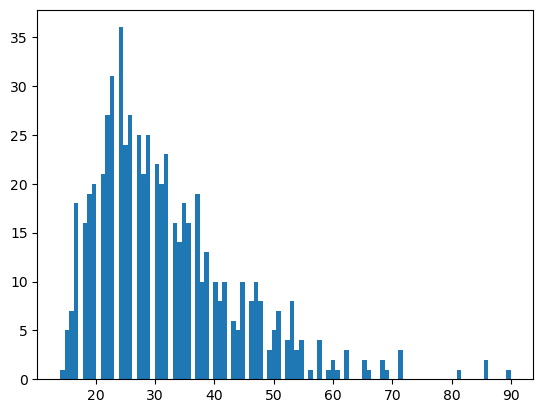

In [91]:
nhood_size = np.array(concatenated_data3.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [92]:
milo.count_nhoods(concatenated_data3, sample_col="rep_code")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [93]:
concatenated_data3.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 628 × 14
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [94]:
milo.DA_nhoods(concatenated_data3, design="~ cond_continuous")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:306: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:307: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [95]:
milo_results = concatenated_data3.uns["nhood_adata"].obs

In [96]:
milo_results

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,AACCATAAGCTCATTG-1-P1-TD-d8,33.845432,-0.036807,12.098938,8.265093,7.259617e-03,3.352235e-02,3.115483e-02
1,AACGTTAAGTAACGTA-1-P1-TD-d8,28.863098,-0.041415,12.269045,11.427652,1.978442e-03,1.044085e-02,9.652213e-03
2,AACTAAGTCAAGTTAG-1-P1-TD-d8,34.169662,-0.093526,12.061212,23.397644,4.781256e-05,4.481536e-04,4.017034e-04
3,AAGCATGGTATTTCGA-1-P1-TD-d8,27.133823,-0.058896,12.088640,13.856663,7.890815e-04,4.906368e-03,4.589311e-03
4,AAGGAACCACCTTTGG-1-P1-TD-d8,28.139862,-0.063207,12.103499,18.061094,1.829900e-04,1.384551e-03,1.270494e-03
...,...,...,...,...,...,...,...,...
623,TCGAAGTAGTCATGAA-1-P5-T0-d15,44.209122,0.031612,11.688151,6.478534,1.613892e-02,6.756829e-02,6.294601e-02
624,TCTAATGGTATTTCGA-1-P5-T0-d15,35.231892,0.040535,12.075624,16.636233,2.953511e-04,2.140948e-03,1.987865e-03
625,TGTAAGTCACAGCCAG-1-P5-T0-d15,27.592459,0.075085,12.663625,113.942043,6.988673e-12,4.388886e-09,3.402149e-09
626,TTGTGGACAAGGTGCT-1-P5-T0-d15,26.152866,0.059527,12.520556,70.500297,1.814597e-09,8.139763e-08,6.383916e-08


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


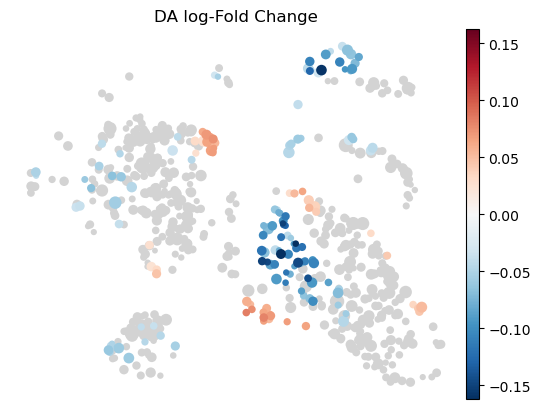

<Figure size 640x480 with 0 Axes>

In [97]:
milopy.utils.build_nhood_graph(concatenated_data3)
milopy.plot.plot_nhood_graph(concatenated_data3, alpha=0.1, min_size=5)
plt.tight_layout()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


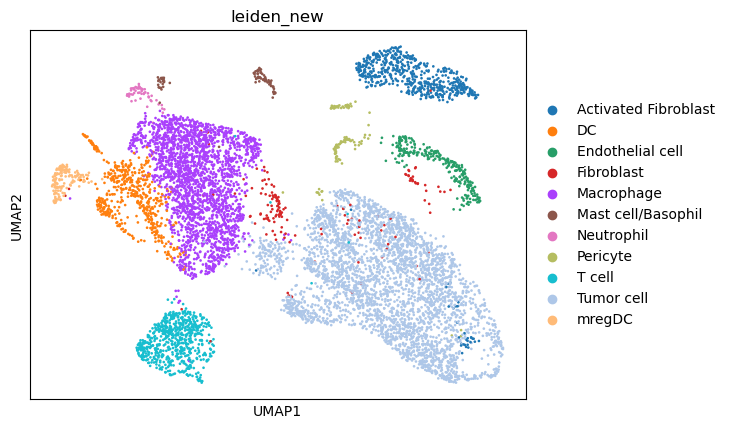

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


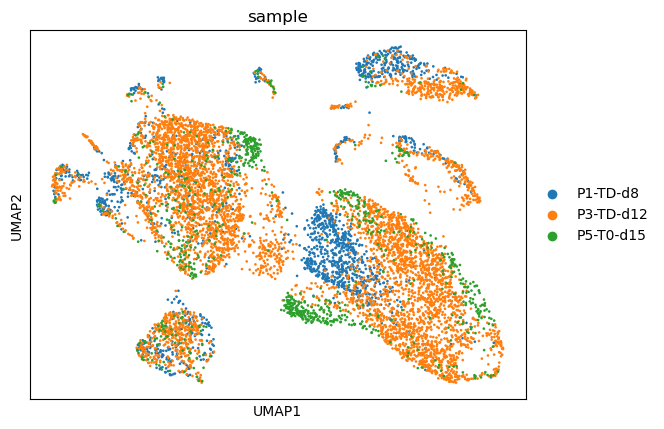

In [118]:
sc.pl.umap(concatenated_data3, color = 'leiden_new')
sc.pl.umap(concatenated_data3, color = 'sample')

In [102]:
milopy.utils.annotate_nhoods(concatenated_data3, anno_col='leiden_new')

Text(0.5, 0, 'celltype fraction')

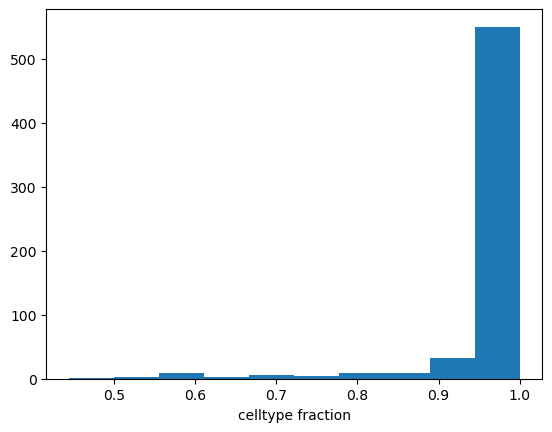

In [104]:
plt.hist(concatenated_data3.uns['nhood_adata'].obs["nhood_annotation_frac"])
plt.xlabel("celltype fraction")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


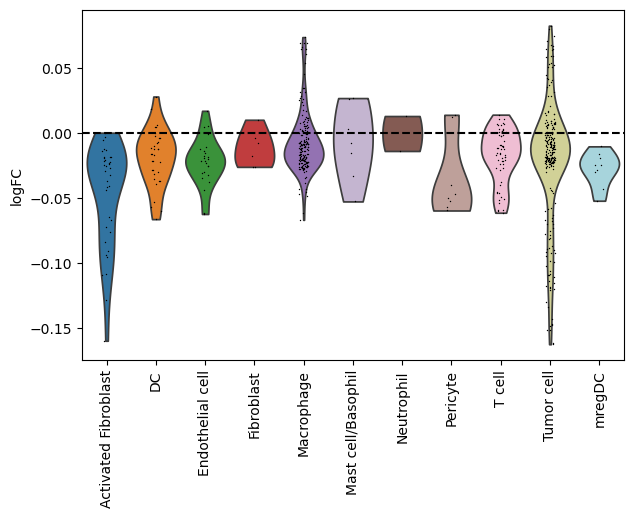

In [117]:
sc.pl.violin(concatenated_data3.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False, palette=celltype_dict)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [116]:
celltype_dict = {'Activated Fibroblast': sns.color_palette('tab20', 20)[0],
                 'DC': sns.color_palette('tab20', 20)[2],
                 'Endothelial cell': sns.color_palette('tab20', 20)[4],
                 'Fibroblast': sns.color_palette('tab20', 20)[6],
                 'Macrophage': sns.color_palette('tab20', 20)[8],
                 'Mast cell/Basophil': sns.color_palette('tab20', 20)[9],
                 'Neutrophil': sns.color_palette('tab20', 20)[10],
                 'Pericyte': sns.color_palette('tab20', 20)[11],
                 'T cell': sns.color_palette('tab20', 20)[13],
                 'Tumor cell': sns.color_palette('tab20', 20)[17],
                 'mregDC': sns.color_palette('tab20', 20)[19]
               }

In [119]:
from community import community_louvain
import networkx as nx

In [120]:
test_adj2 = group_nhoods(concatenated_data3, 2, 1.5)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_59068/1680834334.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:


In [121]:
G_test1 = nx.from_numpy_array(test_adj2)

In [122]:
from distinctipy import distinctipy

In [123]:
partition = community_louvain.best_partition(G_test1)

24


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib

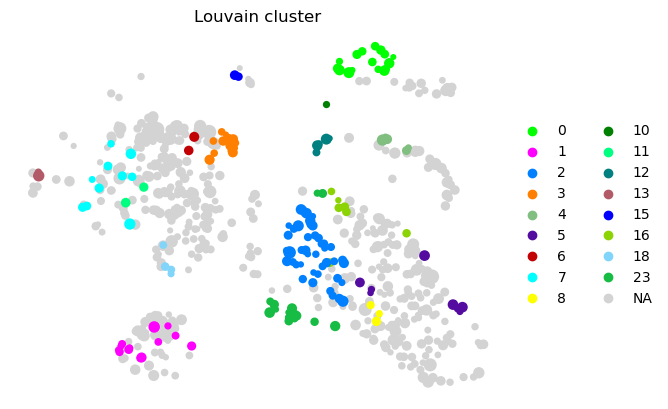

<Figure size 640x480 with 0 Axes>

In [124]:
print(np.max(list(partition.values())))
louvain_lab0, louvain_pal0 = plot_nhood_clusters(concatenated_data3, list(partition.values()), 'Louvain cluster', alpha=0.1, min_size=5)
plt.tight_layout()

In [135]:
concatenated_data3.uns['nhood_adata'].obs['louvain'] = louvain_lab0
louvain_order = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 18, 23])
louvain_order_int = [int(key) for key in louvain_order]

In [130]:
louvain_lab0

274    NaN
478    NaN
130    NaN
576    NaN
257    NaN
      ... 
19       0
129      2
597     23
603      3
625     23
Name: graph_color, Length: 628, dtype: category
Categories (17, int64): [0, 1, 2, 3, ..., 15, 16, 18, 23]

In [131]:
louvain_pal0

{0: (0.0, 1.0, 0.0),
 1: (1.0, 0.0, 1.0),
 2: (0.0, 0.5, 1.0),
 3: (1.0, 0.5, 0.0),
 4: (0.5, 0.75, 0.5),
 5: (0.32455244740203115, 0.04250517110067975, 0.628944059460142),
 6: (0.7613624946609437, 0.001978338218923681, 0.02062118066976737),
 7: (0.0, 1.0, 1.0),
 8: (1.0, 1.0, 0.0),
 9: (0.9453224502843212, 0.49879904159245936, 0.8671451491058378),
 10: (0.0, 0.5, 0.0),
 11: (0.0, 1.0, 0.5),
 12: (0.0, 0.5, 0.5),
 13: (0.7001671852895792, 0.3528462969616295, 0.40738394190842186),
 14: (0.5853067976208481, 0.21628830756917494, 0.9970805470860936),
 15: (0.0, 0.0, 1.0),
 16: (0.5441330564412322, 0.8264007212013949, 0.009601284303519808),
 17: (0.9877545240704446, 0.7854899518881641, 0.490955046930881),
 18: (0.5043312512093522, 0.8342195438803942, 0.9800815078534155),
 19: (0.40115866371523023, 0.1940235263087393, 0.12970146843466024),
 20: (0.9667847678183135, 0.040532273002816255, 0.45511901566495205),
 21: (0.5, 0.5, 0.0),
 22: (0.3649453899595402, 0.4753070280567333, 0.75934717034463

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


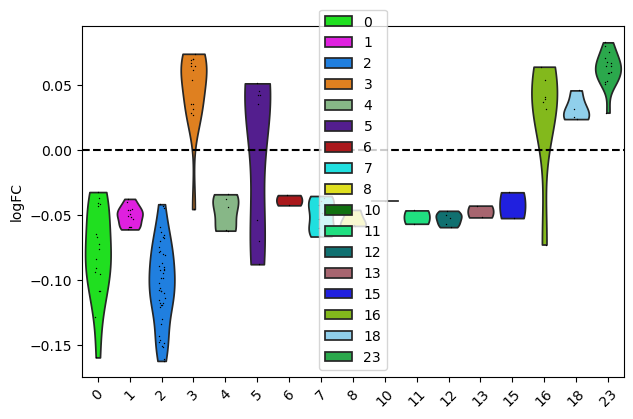

In [139]:
louvain_pal0_int = {int(key): value for key, value in louvain_pal0.items()}

# Use the converted palette in the plot
sc.pl.violin(concatenated_data3.uns['nhood_adata'], "logFC", groupby="louvain", hue = "louvain",show=False, palette=louvain_pal0_int,
             order=louvain_order_int, rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


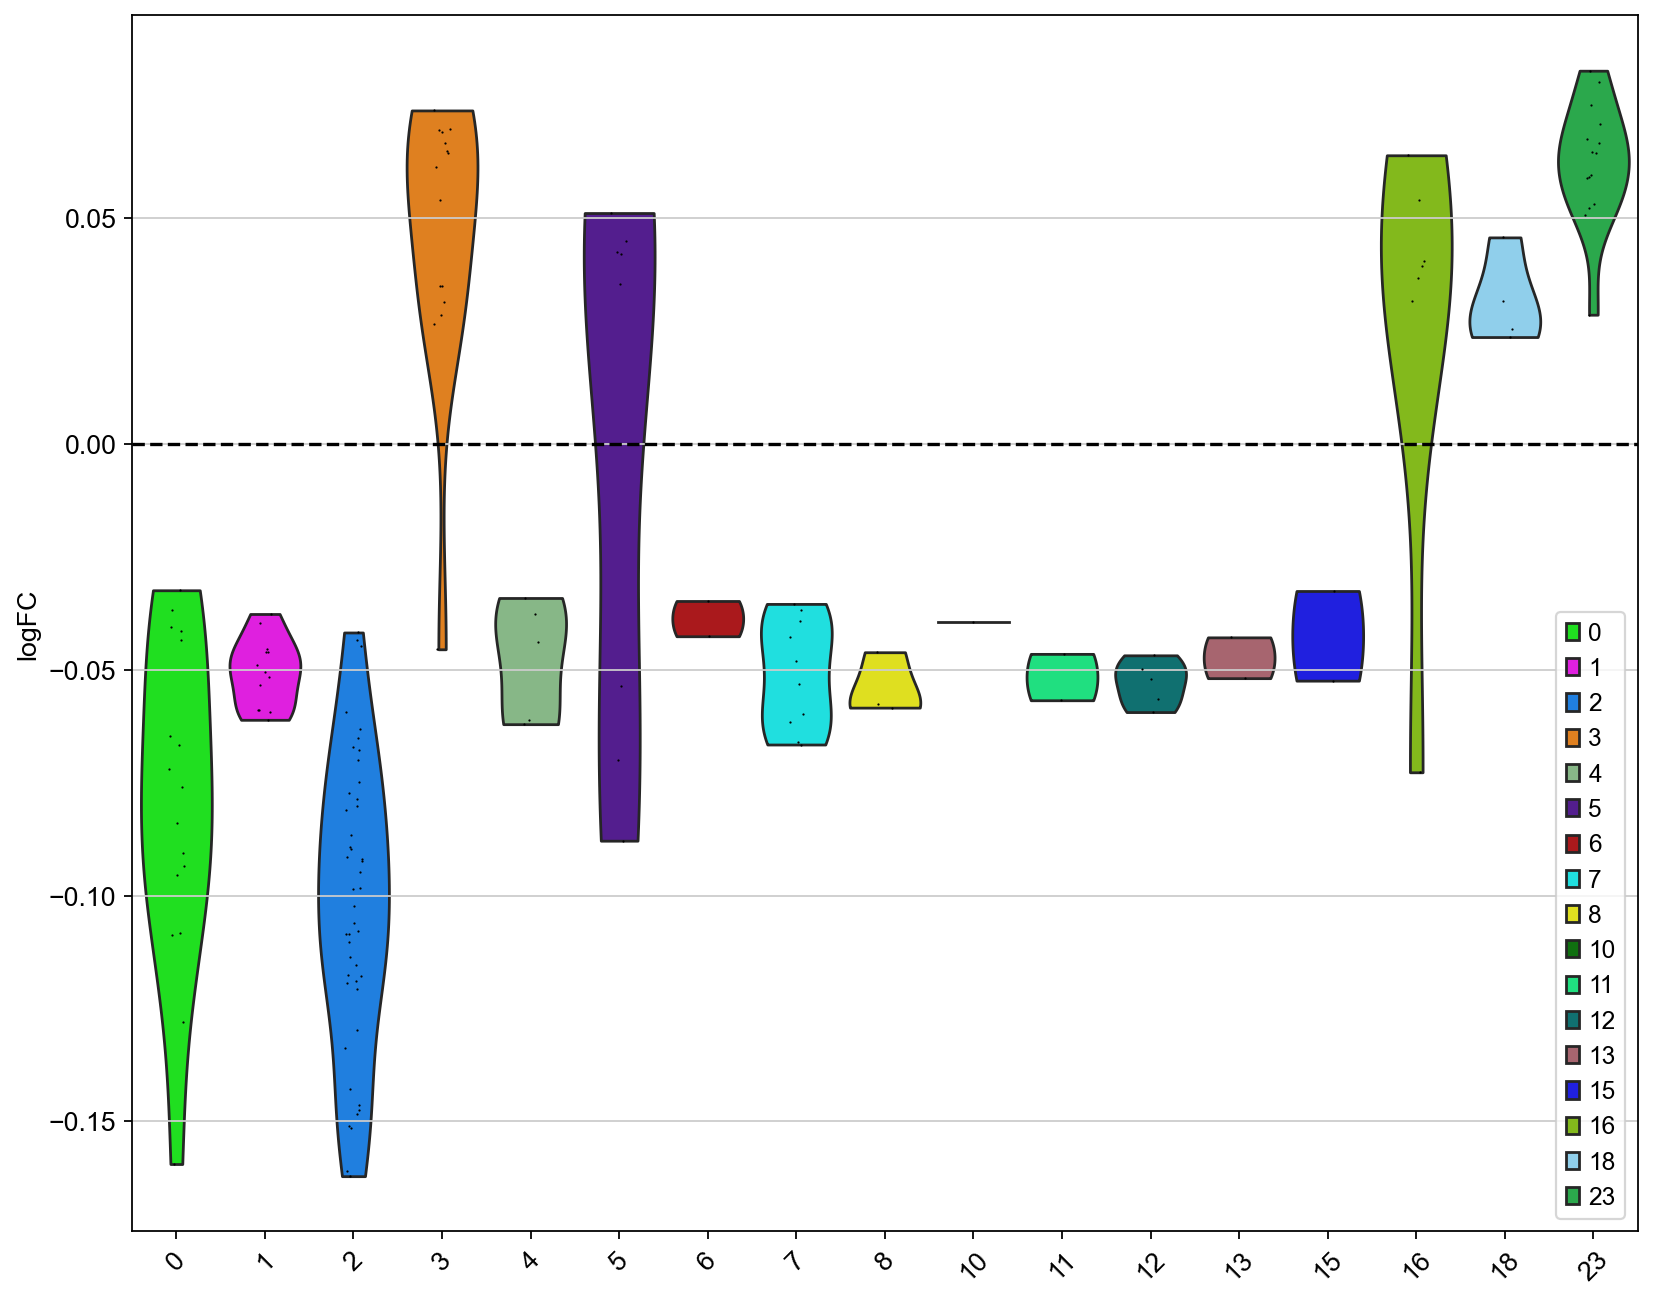

In [149]:
sc.set_figure_params(figsize=(10, 10), fontsize=12)
sc.pl.violin(concatenated_data3.uns['nhood_adata'], "logFC", groupby="louvain", hue = "louvain",show=False, palette=louvain_pal0_int,
             order=louvain_order_int, rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [140]:
concatenated_data3.obs['sc_louvain'] = get_sc_louvain(concatenated_data3)
concatenated_data3.obs['sc_louvain'] = concatenated_data3.obs['sc_louvain'].astype('category')
concatenated_data3.obs['louvain_str'] = list(map(str, concatenated_data3.obs['sc_louvain'].values))

In [146]:
corr_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 18, 23]
cat = ['P1-TD-d8', 'P1-TD-d8','P1-TD-d8','P1-TD-d8','P1-TD-d8','P1-TD-d8', 
       'P3-TD-d12','P3-TD-d12','P3-TD-d12','P3-TD-d12', 
       'P5-T0-d15','P5-T0-d15','P5-T0-d15','P5-T0-d15','P5-T0-d15','P5-T0-d15']

for f in np.unique(concatenated_data3.obs['sc_louvain']):
    clust = concatenated_data3[concatenated_data3.obs['sc_louvain'] == f]
    counts = [len(np.where(clust.obs['sample_rep'] == j)[0]) for j in np.unique(concatenated_data3.obs['sample_rep'])[corr_ind]]
    plot_df = pd.DataFrame({'sample': cat, 'single cells': counts})
    plt.figure()
    sns.barplot(data=plot_df, x="sample", y="single cells", ci=80, capsize=.2,
                palette=sample_dict).set_title(f)


IndexError: index 15 is out of bounds for axis 0 with size 14

In [147]:
corr_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 18, 23]
cat = ['P1-TD-d8', 'P1-TD-d8','P1-TD-d8','P1-TD-d8','P1-TD-d8','P1-TD-d8', 
       'P3-TD-d12','P3-TD-d12','P3-TD-d12','P3-TD-d12', 
       'P5-T0-d15','P5-T0-d15','P5-T0-d15','P5-T0-d15','P5-T0-d15','P5-T0-d15']

# Make sure that corr_ind is within the bounds of the concatenated_data3.obs['sc_louvain'] array
corr_ind = [ind for ind in corr_ind if ind < len(concatenated_data3.obs['sc_louvain'])]

for f in np.unique(concatenated_data3.obs['sc_louvain']):
    clust = concatenated_data3[concatenated_data3.obs['sc_louvain'] == f]
    
    # Make sure that the indices used for slicing are within the bounds of the data
    counts = [len(np.where(clust.obs['sample_rep'] == j)[0]) for j in np.unique(concatenated_data3.obs['sample_rep'])[corr_ind]]
    
    plot_df = pd.DataFrame({'sample': cat, 'single cells': counts})
    
    plt.figure()
    sns.barplot(data=plot_df, x="sample", y="single cells", ci=80, capsize=.2, palette=sample_dict).set_title(f)


IndexError: index 15 is out of bounds for axis 0 with size 14

In [150]:
concatenated_data3.obs['leiden_new']

AAACCAGGTCATGAAG-1-P1-TD-d8               Macrophage
AAACGGGCAGTTATGG-1-P1-TD-d8     Activated Fibroblast
AAACTGGGTATTCGAC-1-P1-TD-d8               Macrophage
AAACTGGGTGCACTAT-1-P1-TD-d8     Activated Fibroblast
AAACTGGGTTACTCCC-1-P1-TD-d8               Tumor cell
                                        ...         
TTTGCTCTCGATTGGG-1-P5-T0-d15                      DC
TTTGGACGTAGTAGCA-1-P5-T0-d15                      DC
TTTGGACGTGGTTATC-1-P5-T0-d15              Macrophage
TTTGGCGGTTTACTGA-1-P5-T0-d15              Tumor cell
TTTGTGAGTCGTTCTC-1-P5-T0-d15                  T cell
Name: leiden_new, Length: 8231, dtype: category
Categories (11, object): ['Activated Fibroblast', 'DC', 'Endothelial cell', 'Fibroblast', ..., 'Pericyte', 'T cell', 'Tumor cell', 'mregDC']

In [151]:
celltype_group = {'Activated Fibroblast': 'Non-immune',
                  'DC': 'MDP',
                  'Endothelial cell': 'Non-immune',
                  'Fibroblast': 'Non-immune',
                  'Macrophage': 'MDP',
                  'Mast cell/Basophil': 'Granulo',
                  'Neutrophil': 'Granulo',
                  'Pericyte': 'Non-immune',
                  'T cell': 'T-cell',
                  'Tumor cell': 'Non-immune',
                  'mregDC': 'MDP'
                  }

In [153]:
concatenated_data3.obs['celltype_cat'] = concatenated_data3.obs['leiden_new'].map(celltype_group)

In [154]:
concatenated_data3.obs['celltype_cat']

AAACCAGGTCATGAAG-1-P1-TD-d8            MDP
AAACGGGCAGTTATGG-1-P1-TD-d8     Non-immune
AAACTGGGTATTCGAC-1-P1-TD-d8            MDP
AAACTGGGTGCACTAT-1-P1-TD-d8     Non-immune
AAACTGGGTTACTCCC-1-P1-TD-d8     Non-immune
                                   ...    
TTTGCTCTCGATTGGG-1-P5-T0-d15           MDP
TTTGGACGTAGTAGCA-1-P5-T0-d15           MDP
TTTGGACGTGGTTATC-1-P5-T0-d15           MDP
TTTGGCGGTTTACTGA-1-P5-T0-d15    Non-immune
TTTGTGAGTCGTTCTC-1-P5-T0-d15        T-cell
Name: celltype_cat, Length: 8231, dtype: object

In [168]:
type_groups = []
for b in ['MDP']:
    # sc obj for each type category, DEGs for louvain clusters, write to file
    celltype = concatenated_data3[np.where(concatenated_data3.obs['celltype_cat'] == b)]
    #del celltype.obsm['X_umap'], celltype.obsm['X_diffmap'], celltype.obsm['X_pca']

In [169]:
celltype.obs['leiden_new']

AAACCAGGTCATGAAG-1-P1-TD-d8     Macrophage
AAACTGGGTATTCGAC-1-P1-TD-d8     Macrophage
AAACTGTCACAACATG-1-P1-TD-d8     Macrophage
AAAGATGCAAGAACAA-1-P1-TD-d8     Macrophage
AAAGTCATCTATCACG-1-P1-TD-d8     Macrophage
                                   ...    
TTGTACGTCGCTTCGG-1-P5-T0-d15    Macrophage
TTTGCGGGTGTGACCC-1-P5-T0-d15    Macrophage
TTTGCTCTCGATTGGG-1-P5-T0-d15            DC
TTTGGACGTAGTAGCA-1-P5-T0-d15            DC
TTTGGACGTGGTTATC-1-P5-T0-d15    Macrophage
Name: leiden_new, Length: 2950, dtype: category
Categories (3, object): ['DC', 'Macrophage', 'mregDC']

In [170]:
#celltype
del celltype.obsm['X_umap'], celltype.obsm['X_pca']

View of AnnData object with n_obs × n_vars = 2950 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'replicate', 'sample_rep', 'rep_code', 'cond_continuous', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'sc_louvain', 'louvain_str', 'celltype_cat'
    uns: 'pca', 'neighbors', 'umap', 'sample_rep_colors', 'nhood_neighbors_key', 'nhood_adata', 'leiden_new_colors', 'sample_colors'
    obsm: 'hash_onoff', 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [210]:
sc.tl.rank_genes_groups(concatenated_data3, 'louvain_str', method='wilcoxon', key_added='louvain-wilc')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [186]:
type_groups.append(celltype.copy())

In [213]:
sc.set_figure_params(frameon=False, figsize=(4, 4))

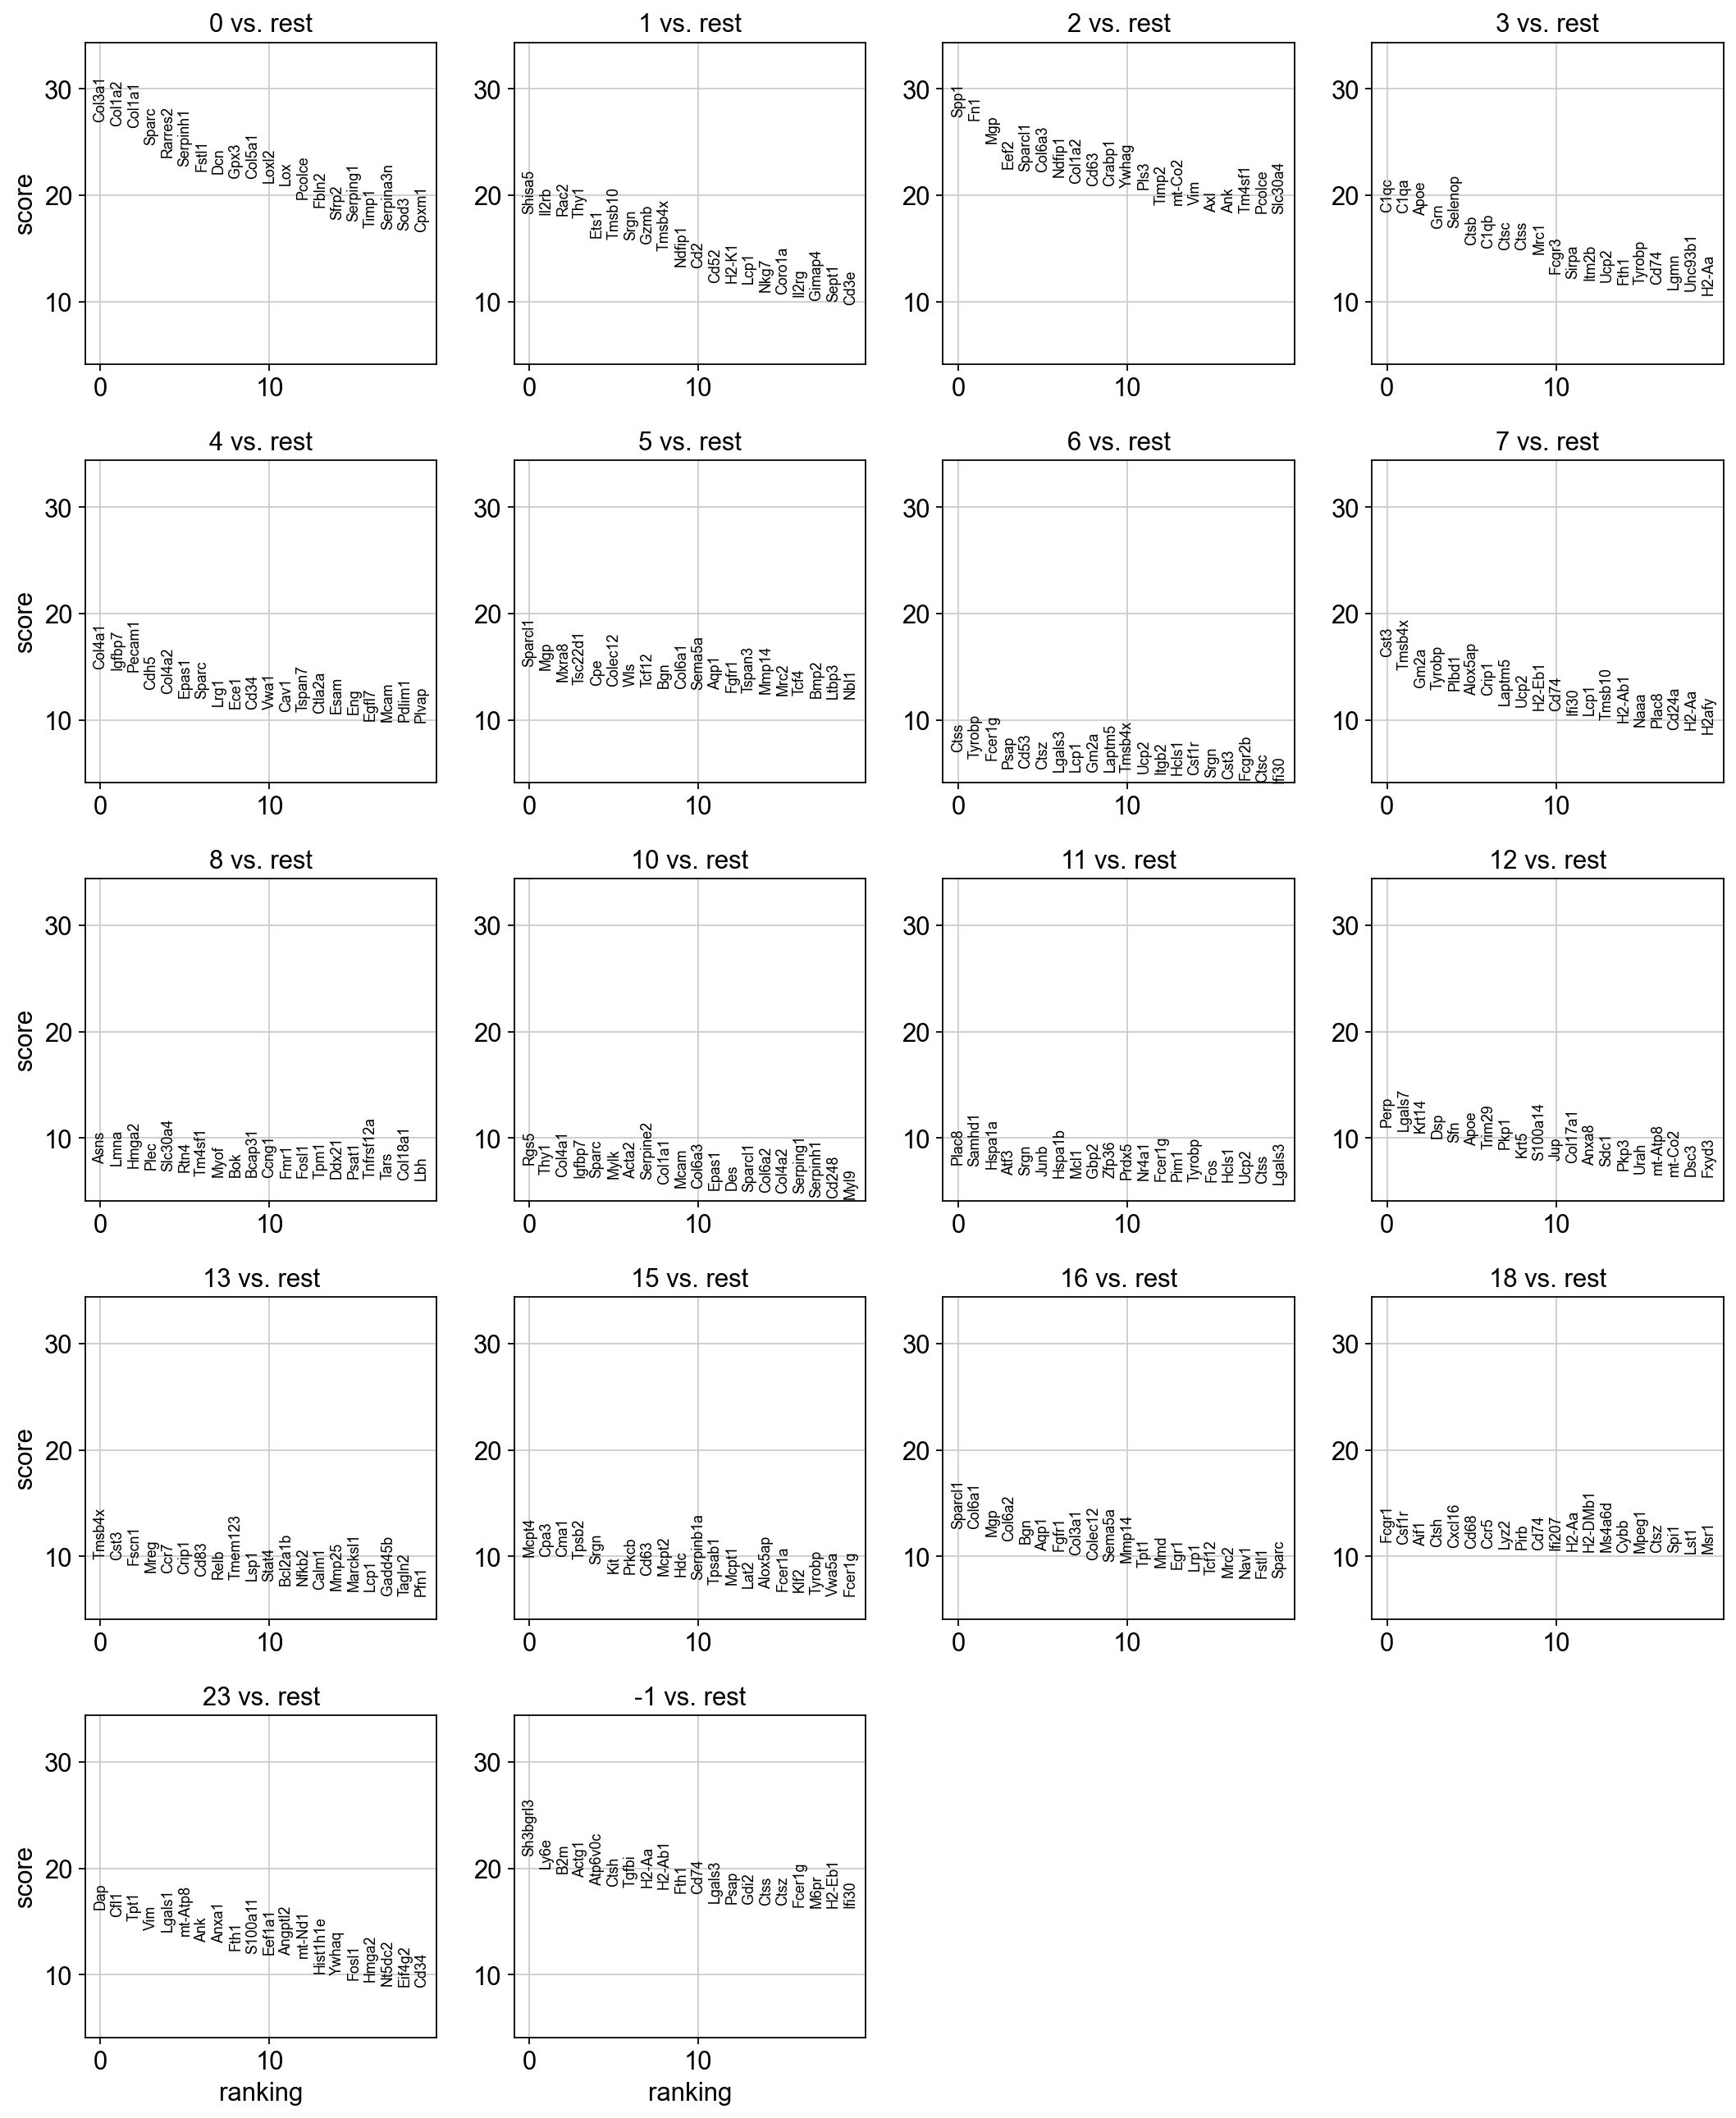

In [214]:
sc.pl.rank_genes_groups(concatenated_data3, key='louvain-wilc')

In [190]:
type_groups[0]

AnnData object with n_obs × n_vars = 2950 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'replicate', 'sample_rep', 'rep_code', 'cond_continuous', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'sc_louvain', 'louvain_str', 'celltype_cat'
    uns: 'pca', 'neighbors', 'umap', 'sample_rep_colors', 'nhood_neighbors_key', 'nhood_adata', 'leiden_new_colors', 'sample_colors', 'louvain-wilc'
    obsm: 'hash_onoff', 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [205]:
mdp_oi = ['Ace', 'Pou2f2', 'Nr4a1','Vegfa', 'Trem2',
          'C1qa', 'Hilpda','Apoe', 'Mrc1', 'Ctsd', 'C1qb', 'Maf', 
          'Tgm2', 'Cxcl10', 'Isg20', 'Fn1', 'Plaur', 'Vcan','Xcr1', 'Clec9a', 
          'Ccr7', 'Ccl22', 'Il12b', 'Ccl5']

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


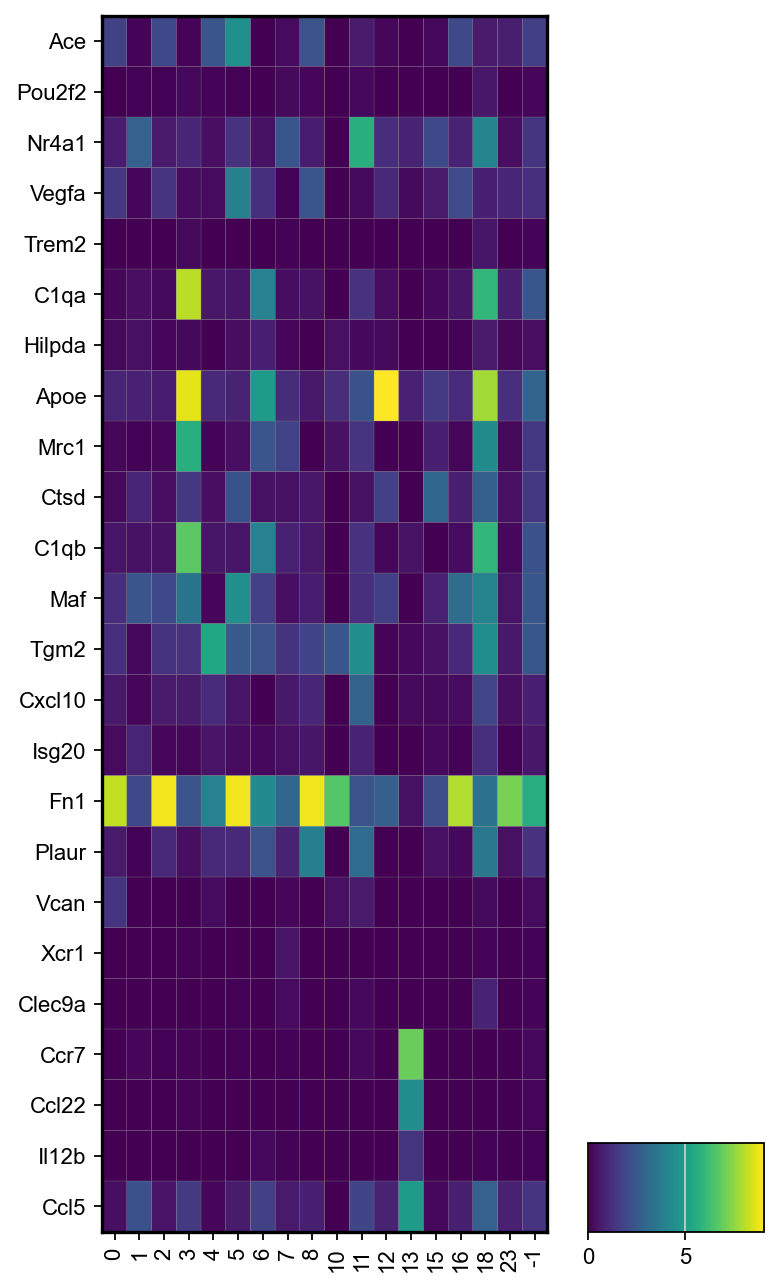

In [208]:
sc.pl.matrixplot(concatenated_data3, mdp_oi, groupby='louvain_str', swap_axes=True, dendrogram=False, figsize=(5.3, 10), colorbar_title='')

In [200]:
concatenated_data3

AnnData object with n_obs × n_vars = 8231 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'replicate', 'sample_rep', 'rep_code', 'cond_continuous', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'sc_louvain', 'louvain_str', 'celltype_cat'
    uns: 'pca', 'neighbors', 'umap', 'sample_rep_colors', 'nhood_neighbors_key', 'nhood_adata', 'leiden_new_colors', 'sample_colors'
    obsm: 'hash_onoff', 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'